# Libraries

In [1]:
!pip install scikit-learn torch wandb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.3 MB/s eta 0:00:00


## Imports

In [2]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, ShuffleSplit
from sklearn.datasets import fetch_olivetti_faces

# Python
from typing import Union, List, Tuple, Dict, Any, AnyStr

# Wandb
import wandb

# Torch
import torch
from torch import nn

# Fundamentals
from typing import Callable, Optional, Tuple, Union
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

# Helper Functions

In [3]:
def plot_gallery(title, images, n_col: Optional[int] = 3, n_row: Optional[int] = 2, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape((64, 64)),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

# Loss Functions

## Binary Crossentropy

In [4]:
def binary_crossentropy(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
    ) -> torch.Tensor:

    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

## Multi-class Crossentropy

In [5]:
def multiclass_crossentropy(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
    ) -> torch.Tensor:

    return -torch.mean(torch.sum(y_true * torch.log(y_pred), dim=1))

# Optimization Algorithms

In [6]:
class AdamOptimizer():
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (param.grad ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# Training Loops

In [93]:
def _train(
    training_features: torch.Tensor,
    training_labels: torch.Tensor,
    validation_features: torch.Tensor,
    validation_labels: torch.Tensor,
    model: nn.Module,
    optimizer: AdamOptimizer,
    loss_function: nn.Module,
    epochs: int
):
    training_loss: List[float] = []
    validation_loss: List[float] = []
    training_accuracy: List[float] = []
    validation_accuracy: List[float] = []

    for epoch in range(epochs):
        model.train()

        training_ypred = model(training_features)
        train_loss = loss_function(training_ypred, training_labels)
        training_loss.append(train_loss.item())

        _, predicted = torch.max(training_ypred, 1)
        correct = (predicted == training_labels).sum().item()
        accuracy = correct / training_labels.size(0)
        training_accuracy.append(accuracy)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            validation_ypred = model(validation_features)
            val_loss = loss_function(validation_ypred, validation_labels)
            validation_loss.append(val_loss.item())

            _, val_predicted = torch.max(validation_ypred, 1)
            val_correct = (val_predicted == validation_labels).sum().item()
            val_accuracy = val_correct / validation_labels.size(0)
            validation_accuracy.append(val_accuracy)

        wandb.log({
            "epoch": epoch,
            "training_loss": train_loss.item(),
            "validation_loss": val_loss.item(),
            "training_accuracy": accuracy,
            "validation_accuracy": val_accuracy
        })

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Training Loss = {train_loss.item():.4f} | Validation Loss = {val_loss.item():.4f} | Training Acc = {accuracy:.4f} | Validation Acc = {val_accuracy:.4f}")

    return training_loss, validation_loss, training_accuracy, validation_accuracy

# Dataset

In [101]:
X, y = olivetti_faces = fetch_olivetti_faces(shuffle=True, return_X_y=True)

In [102]:
X.shape, y.shape

((400, 4096), (400,))

## Preprocessing

In [103]:
Inner_X, Inner_y = X[:int(len(X)*0.9)]  / 1.0, y[:int(len(X)*0.9)] # 90% as inner training/validation
Outer_X, Outer_y = X[int(len(X)*0.9):] / 1.0 , y[int(len(X)*0.9):] # 10% as outer predictions

Inner_X_train, Inner_X_test = Inner_X[:int(len(Inner_X)*0.75)], Inner_X[int(len(Inner_X)*0.75):]
Inner_y_train, Inner_y_test = Inner_y[:int(len(Inner_y)*0.75)], Inner_y[int(len(Inner_y)*0.75):]

In [104]:
datasets: List[Any] = [Inner_X, Inner_y, Outer_X, Outer_y, Inner_X_train, Inner_X_test, Inner_y_train, Inner_y_test]
for dataset in datasets:
  print(dataset.shape)

(360, 4096)
(360,)
(40, 4096)
(40,)
(270, 4096)
(90, 4096)
(270,)
(90,)


In [106]:
n_samples, n_features = X.shape
faces_centered = X - X.mean(axis=0)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


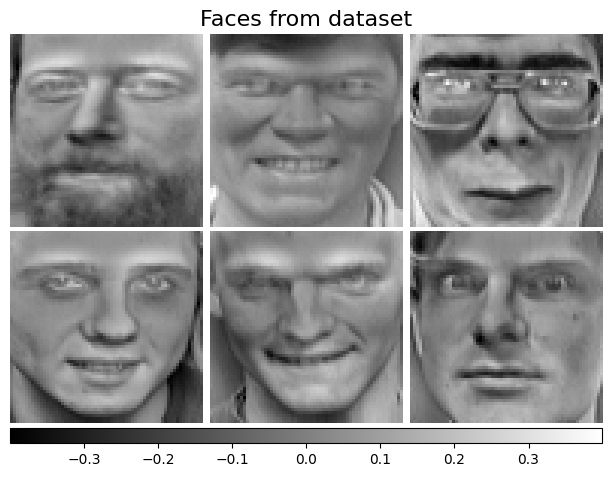

In [13]:
plot_gallery("Faces from dataset", faces_centered[-6:])

In [98]:
print(Inner_y_train[:5])

[13 30 34 19 24]


In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [108]:
Inner_X_train_reshaped = Inner_X_train.reshape(-1, 1, 64, 64)
Inner_X_test_reshaped = Inner_X_test.reshape(-1, 1, 64, 64)

Inner_X_train_tensor = torch.tensor(Inner_X_train_reshaped, dtype=torch.float32).to(device)
Inner_X_test_tensor = torch.tensor(Inner_X_test_reshaped, dtype=torch.float32).to(device)

Inner_y_train_tensor = torch.tensor(Inner_y_train, dtype=torch.long).to(device)
Inner_y_test_tensor = torch.tensor(Inner_y_test, dtype=torch.long).to(device)

## Exploratory Data Analysis

# Modelling

## Model Architecture

In [109]:
class NNModel(nn.Module):

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        kernel_size: int,
        stride: Tuple[int, int],
        pooling_size: int,
        device: torch.device
    ):
        super(NNModel, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=input_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            device=device,
            dtype=torch.float32
        )

        self.conv2 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            device=device,
            dtype=torch.float32
        )

        self.conv3 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            device=device,
            dtype=torch.float32
        )

        self.maxpooling = nn.MaxPool2d(
            kernel_size=pooling_size,
            stride=pooling_size
        )

        self.flat = nn.Flatten()
        self.relu = nn.ReLU()

        self.dense_layer = nn.Linear(
            in_features=hidden_dim * 32 * 32,
            out_features=hidden_dim,
            device=device,
            dtype=torch.float32
        )

        self.output_layer = nn.Linear(
            in_features=hidden_dim,
            out_features=output_dim,
            device=device,
            dtype=torch.float32
        )


    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpooling(x)
        x = self.flat(x)
        x = self.dense_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)

        return x

In [118]:
wandb.login()
wandb.init(project="olivetti_cnn_project", config={
    "input_dim": 1,
    "hidden_dim": 512,
    "output_dim": 40,
    "kernel_size": 3,
    "stride_conv": (1, 1),
    "pooling_size": 2,
    "learning_rate": 1e-5,
    "epochs": 256
})

## Training

In [119]:
model = NNModel(
    input_dim=wandb.config.input_dim,
    hidden_dim=wandb.config.hidden_dim,
    output_dim=wandb.config.output_dim,
    kernel_size=wandb.config.kernel_size,
    stride=wandb.config.stride_conv,
    pooling_size=wandb.config.pooling_size,
    device=device
).to(device)

model.initialize_weights()
optimizer = AdamOptimizer(model.parameters(), lr=wandb.config.learning_rate)
loss_function = nn.CrossEntropyLoss()

epochs = wandb.config.epochs
train_loss, val_loss, train_acc, val_acc = _train(
    training_features=Inner_X_train_tensor,
    training_labels=Inner_y_train_tensor,
    validation_features=Inner_X_test_tensor,
    validation_labels=Inner_y_test_tensor,
    model=model,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=epochs
)

wandb.finish()

Epoch 0: Training Loss = 3.6892 | Validation Loss = 3.6964 | Training Acc = 0.0185 | Validation Acc = 0.0111
Epoch 10: Training Loss = 3.5625 | Validation Loss = 3.7706 | Training Acc = 0.0963 | Validation Acc = 0.0222
Epoch 20: Training Loss = 3.3408 | Validation Loss = 3.5841 | Training Acc = 0.3111 | Validation Acc = 0.0778
Epoch 30: Training Loss = 2.9133 | Validation Loss = 3.2828 | Training Acc = 0.5333 | Validation Acc = 0.2556
Epoch 40: Training Loss = 2.2116 | Validation Loss = 2.7530 | Training Acc = 0.7481 | Validation Acc = 0.4111
Epoch 50: Training Loss = 1.2929 | Validation Loss = 1.9472 | Training Acc = 0.8963 | Validation Acc = 0.6667
Epoch 60: Training Loss = 0.5171 | Validation Loss = 1.1374 | Training Acc = 0.9741 | Validation Acc = 0.8000
Epoch 70: Training Loss = 0.1653 | Validation Loss = 0.6741 | Training Acc = 1.0000 | Validation Acc = 0.8778
Epoch 80: Training Loss = 0.0562 | Validation Loss = 0.4734 | Training Acc = 1.0000 | Validation Acc = 0.8889
Epoch 90: T

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
training_accuracy,▁▁▂▃▃▅██████████████████████████████████
training_loss,██▇▇▇▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▂▂▃▇▇▇▇███████████████████████████████
validation_loss,████▇▇▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,255
training_accuracy,1
training_loss,0.00037
validation_accuracy,0.92222
validation_loss,0.30759


## Evaluation

* [Training Results](https://api.wandb.ai/links/alone-wolf/2f97krrg)

In [143]:
Outer_X_reshaped = Outer_X.reshape(-1, 1, 64, 64)

Outer_X_tensor = torch.tensor(Outer_X_reshaped, dtype=torch.float32).to(device)
Outer_y_tensor = torch.tensor(Outer_y, dtype=torch.long).to(device)

In [144]:
import torch.nn.functional as F

model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_features, batch_labels in outer_loader:
        logits = model(batch_features)

        _, predicted = torch.max(logits, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(batch_labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

Outer Dataset Accuracy: 0.9250


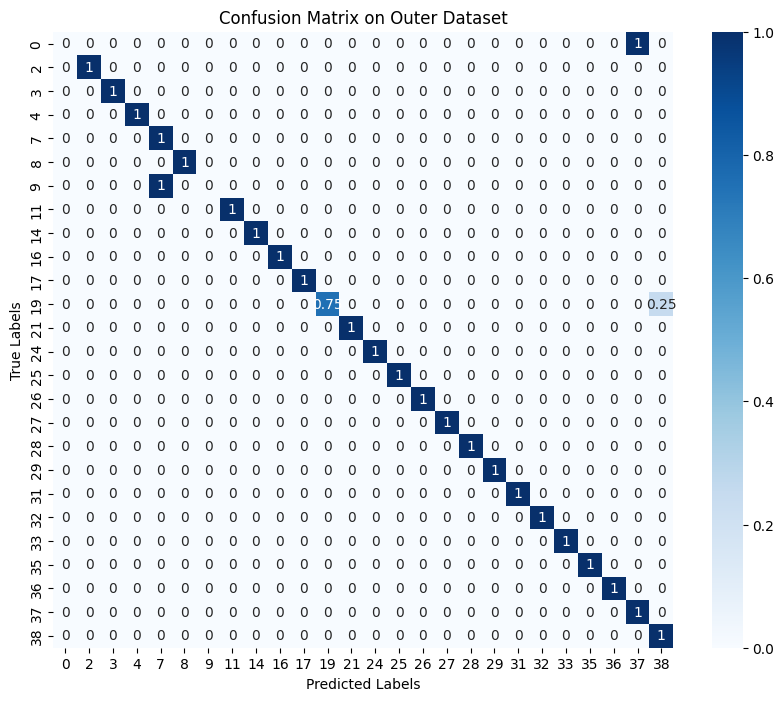

In [152]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Outer Dataset Accuracy: {accuracy:.4f}")

conf_mat = confusion_matrix(all_true_labels, all_predictions, normalize="true")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues',
            xticklabels=np.unique(all_true_labels),
            yticklabels=np.unique(all_true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Outer Dataset')
plt.show()

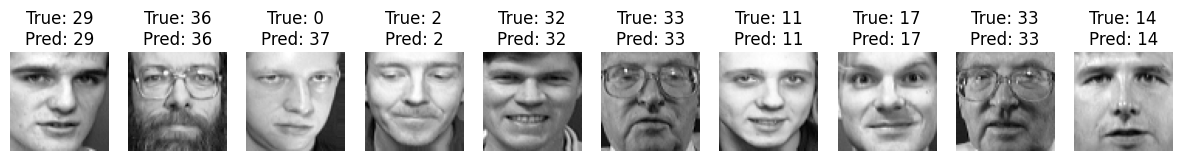

In [156]:
num_samples = 10
sample_indices = np.random.choice(len(Outer_X), num_samples, replace=False)

sample_images = Outer_X_reshaped[sample_indices]
sample_labels = all_true_labels[sample_indices]
sample_predictions = all_predictions[sample_indices]

fig, axes = plt.subplots(1, num_samples, figsize=(15, 9))
for i in range(num_samples):
    ax = axes[i]
    img = sample_images[i].squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {sample_labels[i]}\nPred: {sample_predictions[i]}")
    ax.axis('off')
plt.show()

plt.close(fig)

# Save & Load Trained Model

In [158]:
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "model.pth"
save_path = model_path / model_name

torch.save(model.state_dict(), save_path)

In [160]:
loaded_model = NNModel(
    input_dim=1,
    hidden_dim=512,
    output_dim=40,
    kernel_size=3,
    stride=(1,1),
    pooling_size=2,
    device=device
).to(device)

loaded_model.load_state_dict(torch.load(save_path))
loaded_model.eval()

<ipython-input-160-5754990d473f>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(save_path))


NNModel(
  (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dense_layer): Linear(in_features=524288, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=40, bias=True)
)